# A simple RBC model in sequence space

In this notebook we showcase the general workflow of setting up and solving dynamic general equilibrium models in sequence space. The process is the exactly the same for heterogeneous-agent models, once the heterogeneous agent (HA) "blocks" are specified.

The notebook accompanies the working paper by Auclert, Bardóczy, Rognlie, Straub (2019): "Using the Sequence-Space Jacobian to Solve and Estimate Heterogeneous-Agent Models". Please see the [Github repository](https://github.com/shade-econ/sequence-jacobian) for more information and code.

## Model description

Let's take a standard RBC model with the following equilibrium conditions.

$$
\textbf{H}_t(\textbf{U}, Z) \equiv 
\begin{pmatrix}
C_t^{-\sigma} - \beta (1 + r_{t+1}) C_{t+1}^{-\sigma}
\\
w_t - \varphi L_t^{\nu} C_t^{\sigma}
\\
K_t - (1 - \delta) K_{t-1} - I_t
\\
r_t + \delta -\alpha Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha-1}
\\
w_t - (1-\alpha) Z_t \left(\frac{K_{t-1}}{L_t} \right)^{\alpha}
\\
Y_t - Z_t K_{t-1}^\alpha L_t^{1-\alpha}
\\
Y_t - C_t - I_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\qquad t = 0, 1, \dots 
\tag{1}
$$

As usual, labor market clearing is imposed implicitly and asset market clearing is omitted by Walras's law.

## 0 Import packages
The first two are standard python packages, the rest contain code we wrote for this project.

In [1]:
# Add the relative path to the top-level of the "sequence-jacobian" folder
# to be able to access the sequence_jacobian module
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import sequence_jacobian as sj
from sequence_jacobian import simple, helper

## 1 Model blocks and the Directed Acyclic Graph (DAG)

The first step of solving the model is to come up with a Directed Acyclic Graph (DAG) representation for it and specify its building blocks.

These blocks are collections of the model's equilibrium conditions, typically written in terms of the conceptual components of the model --- firm, household, market clearing conditions --- where each block takes a set of parameters and variables as inputs and produces another set as outputs.

The DAG serves as the organizing framework for these blocks, which reduce the total set of variables and equations from those in the equilibrium conditions to the minimum number of target equations and associated unknown variables/parameters needed to represent the same system. The rest of the variables/equations in the system can then be written as explicit functions of these unknowns and collected into blocks.

### Constructing a valid DAG
Valid unknowns for a DAG are any variables/parameters that are inputs to a subset of the blocks but are not outputs. 

Likewise, valid targets are variables (or implicit equations) that are outputs of a subset of the blocks but not inputs. 

The only other requirement is that each unknown must map to at least one target and each target likewise must be mapped to by at minimum one unknown.

### The RBC DAG
The 7 equations of the RBC model can be organized as three simple blocks to form a DAG in two unknowns $\{K, L\}$ and two targets, the euler equation and goods market clearing:

![Directed Acyclic Graph for RBC model](../figures/rbc_dag.png) 

**Note**: In the above DAG, we omit the various other variables/parameters that are pre-specified so the figure does not become too cluttered. However, one could visualize other variables such as the capital depreciation rate, $\delta = 0.025$ in our standard calibration, as being defined outside of the DAG --- they could be potential unknowns but in this configuration we simply fix their values.

### Simple blocks

In our code, simple blocks are specified as regular Python functions  endowed with the decorator ``@simple``. In the body of the function, we directly implement the corresponding equilibrium conditions as described above. The decorator turns the function into an instance of ``SimpleBlock``, a class that, among other things, knows how to handle time displacements such as `K(-1)` to denote 1-period lags and `r(+1)` to denote 1-period leads. In general, one can write (-s) and (+s) to denote s-period lags and leads. 

In [2]:
@simple
def firm(K, L, Z, alpha, delta):
    r = alpha * Z * (K(-1) / L) ** (alpha-1) - delta
    w = (1 - alpha) * Z * (K(-1) / L) ** alpha
    Y = Z * K(-1) ** alpha * L ** (1 - alpha)
    return r, w, Y

@simple
def household(K, L, w, eis, frisch, vphi, delta):
    C = (w / vphi / L ** (1 / frisch)) ** eis
    I = K - (1 - delta) * K(-1)
    return C, I

@simple
def mkt_clearing(r, C, Y, I, K, L, w, eis, beta):
    goods_mkt = Y - C - I
    euler = C ** (-1 / eis) - beta * (1 + r(+1)) * C(+1) ** (-1 / eis)
    walras = C + K - (1 + r) * K(-1) - w * L  # we can the check dynamic version too
    return goods_mkt, euler, walras

**Note**: We imported the decorator from the module `simple_model.py`. If you're interested in the inner workings of the SimpleBlock class, check it out.

## 2 Steady state

The next step of solving a model is to compute its steady state. The sequence-jacobian toolkit provides functionality for computing a model's steady state from its DAG representation, but if the user already has a pre-computed steady state they can supply this in the format of a dict(ionary) mapping parameters and variable names to their values.

We will demonstrate two different ways to compute the steady state to illustrate the range of approaches that the sequence-jacobian toolkit provides to solve this portion of the model.

### 2.1 Steady state with a standard DAG

In the first case, we will use almost exactly the same arrangement of the DAG, with two unknowns and two targets to compute the steady state, providing an initial set of fixed variables/parameters.

The one difference is that we will use $\varphi$ (`vphi`) as an unknown instead of $L$ because we want to calibrate the steady state aggregate labor supply $L=1$. Verifying that it is a valid unknown, observe that $\varphi$ influences the $euler$ target indirectly through $L$ mapping into $r$ and the $goods\_mkt$ target indirectly through $L$ mapping into $C$.

Because the `steady_state` function uses a root-finding algorithm, specified in the keyword argument `solver`, one must either provide a set of initial values as given below with $\varphi : 0.9$ and $K : 2.$, or a set of bounds (depending on the solver's requirements), provided as a tuple of numerical values, as in $\varphi : (0.5, 0.99)$.

Targets can also be specified with non-zero values, e.g. if we wanted to target steady state output to be equal to 2, $Y = 2$, we could write it as a key-value pair in the `target` dict(ionary) as $Y : 2$.

In [3]:
# Solving for the steady state as a standard DAG
calibration = {"L": 1., "Z": 1., "r": 0.01, "eis": 1., "frisch": 1., "delta": 0.025, "alpha": 0.11, "beta": 1/(1 + 0.01)}
blocks = [household, firm, mkt_clearing]
unknowns_ss = {"vphi": 0.9, "K": 2.}
targets_ss = {"euler": 0., "goods_mkt": 0.}
ss = sj.steady_state(blocks, calibration, unknowns_ss, targets_ss, solver="broyden_custom")

We can inspect the values contained in the returned dict(ionary) below to confirm that indeed the targets equations have been satisfied with $goods\_mkt \approx 0$ and $euler \approx 0$ and further we have verified that Walras law is also satisfied, by including the resource constraint as an additional variable in the DAG.

However, setting up the DAG with the equations in this particular form does not yield a straightforward way of normalizing $Y = 1$ in steady state. We will explain an alternative method to solve for the steady state next that allows us to perform more general steady state calibrations, without completely disassembling the DAG we've constructed.

In [4]:
ss

{'L': 1.0,
 'Z': 1.0,
 'r': 0.010000000006606863,
 'eis': 1.0,
 'frisch': 1.0,
 'delta': 0.025,
 'alpha': 0.11,
 'beta': 0.9900990099009901,
 'vphi': 0.965891472871577,
 'K': 3.6206932399091794,
 'w': 1.0253144949496455,
 'Y': 1.1520387583703882,
 'C': 1.0615214273518796,
 'I': 0.0905173309977294,
 'walras': -2.077937821809428e-11,
 'goods_mkt': 2.0779156173489355e-11,
 'euler': -6.162292898181931e-12}

### 2.2 Steady state with an analytical solution-augmented DAG

In this next case, we will make use of a new kind of block called a `HelperBlock`, whose purpose is to provide a more flexible way of using the sequence-jacobian toolkit to calibrate a model's steady state. 

A `HelperBlock` works identically to the `SimpleBlock`s that we constructed above using the decorator `@simple` for the end-user, but using the decorator `@helper` instead. Under the hood the sequence-jacobian toolkit handles them differently when the blocks are sorted/used outside of the steady state, like in the computation of the general equilibrium Jacobian which we will get to later. 

Recall in the first case, we wanted to set up the DAG to normalize $Y = 1$. In the case of the RBC model, given our choice of fixed $r = 0.01$, normalizing to $Y = 1$ yields a complete analytical characterization of the steady state. In steps: we choose the discount rate $\beta$ to hit a given real interest rate $r$, the disutility of labor $\varphi$ to hit labor $L=1$, and normalize TFP $Z$ to get output $Y=1$.

In [5]:
@helper
def steady_state_solution(r, eis, delta, alpha):
    rk = r + delta
    Z = (rk / alpha) ** alpha  # normalize so that Y=1
    K = (alpha * Z / rk) ** (1 / (1 - alpha))
    Y = Z * K ** alpha
    w = (1 - alpha) * Z * K ** alpha
    I = delta * K
    C = Y - I
    beta = 1 / (1 + r)
    vphi = w * C ** (-1 / eis)

    return Z, K, Y, w, I, C, beta, vphi

Re-running the steady state code including this additional `HelperBlock` yields a steady state with $Y = 1$.

**Note 1**: Because the solution is entirely analytical it is not necessary to include any `unknown`s. Also, we can specify `solver="solved"` to avoid using a root-finding algorithm. However, given the present structure of the code, we still require that you provide some target values to verify that the steady state given by the analytical solution indeed produces one that satisfies some set of target equations, like the euler equation, goods market clearing, or Walras' Law, as a gut-check to ensure we don't proceed forward with something we don't want!

**Note 2**: If all of your targets are implicit functions, i.e. you want to target their values equal to 0, you can use a list of their names instead of a dict(ionary).

In [6]:
calibration = {"L": 1., "r": 0.01, "eis": 1., "frisch": 1., "delta": 0.025, "alpha": 0.11}
blocks = [household, firm, mkt_clearing, steady_state_solution]
unknowns_ss = {}
targets_ss = ["euler", "goods_mkt"]
ss = sj.steady_state(blocks, calibration, unknowns_ss, targets_ss, solver="solved")

In [7]:
ss

{'L': 1.0,
 'r': 0.009999999999999995,
 'eis': 1.0,
 'frisch': 1.0,
 'delta': 0.025,
 'alpha': 0.11,
 'Z': 0.8816460975214567,
 'K': 3.1428571428571432,
 'Y': 1.0,
 'w': 0.8900000000000001,
 'I': 0.07857142857142874,
 'C': 0.9214285714285713,
 'beta': 0.9900990099009901,
 'vphi': 0.9658914728682173,
 'walras': 0.0,
 'goods_mkt': 0.0,
 'euler': 0.0}

### Steady state in the general case

In practice, your own steady state workflow will likely be somewhere in between the two cases previously described. To compute the steady state it may be easy to analytically solve some portions of the model, but other portions may only be numerically computable, specified as a set of unknowns and targets within a DAG.

Thankfully, any combination of the above two methods is permissible in the sequence-jacobian toolkit. You need only provide the analytical solution component specific to the steady state as a `HelperBlock` in the standard list of blocks, specify your unknowns and targets, and call `steady_state`! You don't even need to swap out the `HelperBlock` from the list of blocks when computing general equilibrium Jacobians or computing non-linear transition dynamics, as we will see next.

## 3 Linearized solution

The linearized impulse responses of the model are fully characterized by the general equilibrium Jacobians $G$. These matrices map *any* sequence of shocks into an impulse response, e.g. $dC = G^{C,Z} dZ.$ Once we have them, we're pretty much done!

We can get all of these in a single call to the function `jacobian.get_G`. This function takes in the model blocks (in arbitrary order), the names of exogenous shocks, the names of unknown endogenous variables, the names of target equations, the truncation horizon, and the steady state dict.

In [11]:
G = sj.get_G(block_list=blocks,
             exogenous=['Z'],
             unknowns=['K', 'L'],
             targets=['euler', 'goods_mkt'],
             T=300, ss=ss)

To see the $G$ matrices in action, let's construct two sequences of TFP shocks. First, a usual autoregressive shock that hits in period 0 (when the economy is assumed to be in steady state). Second, a news shock that, as agents learn in period 0, will hit TFP in period 10 and then decay at a constant rate. Note that such a news shock would be very costly to formulate recursively.

We store the two sequences as columns of a matrix $dZ.$ Let the shock on impact be 1% of steady state productivity, and the  quarterly autocorrelation be 0.8. 

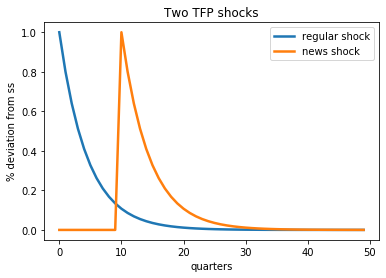

In [12]:
T, impact, rho, news = 300, 0.01, 0.8, 10
dZ = np.empty((T, 2))
dZ[:, 0] = impact * ss['Z'] * rho**np.arange(T)
dZ[:, 1] = np.concatenate((np.zeros(news), dZ[:-news, 0])) 

plt.plot(100*dZ[:50, 0]/ss['Z'], label='regular shock', linewidth=2.5)
plt.plot(100*dZ[:50, 1]/ss['Z'], label='news shock', linewidth=2.5)
plt.title(r'Two TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

Just apply the $G$ matrix to map these into impulses responses for, say, consumption. We multiply by 100 and divide by $C_{ss}$ just to get the answer in units of % deviations from steady state.

In [7]:
dC = 100 * G['C']['Z'] @ dZ / ss['C']

Now plot the result.

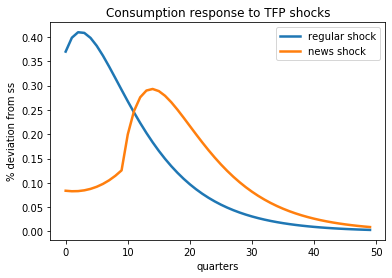

In [8]:
plt.plot(dC[:50, 0], label='regular shock', linewidth=2.5)
plt.plot(dC[:50, 1], label='news shock', linewidth=2.5)
plt.legend()
plt.title(r'Consumption response to TFP shocks')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.show()

For those of you familiar with Dynare, these impulse responses are identical to what you could obtain by running the perfect foresight solver `simul` with the `linear_approximation` option.

## 4 Nonlinear solution

To obtain nonlinear impulse responses that capture the different scale and sign effects of shocks, we use `nonlinear.td_solve`. Similarly to `get_G` above, it takes in the steady state dict, the model blocks (in arbitrary order), the names of unknown endogenous variables and the names of target equations.

However, the names of the exogenous variables would not be sufficient, since we're calculating the nonlinear response to a specific shock. Instead, `td_solve` takes the *sequences* for any exogenous variables that are shocked.

So for the news shock above, we can just call: 

In [9]:
td_nonlin = sj.td_solve(ss=ss, 
                        block_list=[firm, household, mkt_clearing],
                        unknowns=['K', 'L'],
                        targets=['goods_mkt', 'euler'],
                        Z=ss['Z']+dZ[:, 1])

On iteration 0
   max error for goods_mkt is 7.86E-04
   max error for euler is 1.04E-02
On iteration 1
   max error for goods_mkt is 6.75E-05
   max error for euler is 6.68E-05
On iteration 2
   max error for goods_mkt is 1.27E-07
   max error for euler is 3.85E-07
On iteration 3
   max error for goods_mkt is 1.47E-09
   max error for euler is 3.60E-09


As we can see, the linearized solution is very accurate in this case.

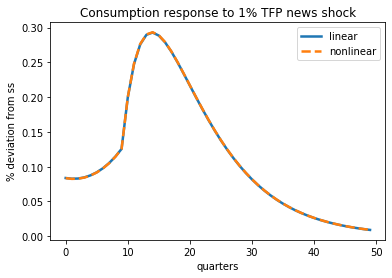

In [10]:
dC_nonlin = 100 * (td_nonlin['C']/ss['C'] - 1)

plt.plot(dC[:50, 1], label='linear', linewidth=2.5)
plt.plot(dC_nonlin[:50], label='nonlinear',  linestyle='--', linewidth=2.5)
plt.title(r'Consumption response to 1% TFP news shock')
plt.ylabel(r'% deviation from ss')
plt.xlabel(r'quarters')
plt.legend()
plt.show()

For those of you familiar with Dynare, these impulse responses are identical to what you could obtain by running the perfect foresight solver `simul`.